### Predicting Residential Housing Prices

**Problem definition:** Predict the final sales price of residential houses in Ames, Iowa.  By analyzing various variables/features of residential real estate and using those features in different modelling approaches, the challenge is to build a predictive model of final sales price.  The goal is to use advanced regression forecasting techniques to make the best possible prediction of house prices.

**Potential clients:** This analysis is a practical application of machine learning techniques to better understand the dynamics of the residential real estate market.  Effective prediction models of housing prices would be useful for mortgage lending firms in primary mortgage origination, banks and financial services firms active in securitizing mortgages, and government sponsored enterprises such as the Federal National Mortgage Association and the Federal Home Loan Mortgage Corporation that create secondary markets for these securities.

**Description of data set and cleaning/wrangling steps:** The Ames Housing dataset was retrieved from [kaggle]( https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). The dataset represents residential properties in Ames, Iowa from 2006 to 2010. There is a train and a test file. The train file has 1460 observations and the test file has 1459 observations. Both datasets contain 79 explanatory variables composed of 46 categorical and 33 continuous variables that describe house features such as neighborhood, square footage, number of full bathrooms, etc. The train file contains the target variable, `SalePrice`, which is what will be predicted in the test set. There is also a unique ID for each house sold, but were not used in fitting the models.

General steps in data cleaning and EDA are:
* Separating the explanatory variables into numeric features and categorical features
* Conducting exploratory data analysis of the numeric features
    * Display the highest and lowest correlations with the `SalePrice` target variable
    * Exploratory graphs of certain features against the target variable
* EDA of categorical features to include a ranked ANOVA score to identify the most influential features as well as exploratory graphs of the categorical data
* Transforming the target variable `SalePrice` to log(1 + `SalePrice`) i.e. `SalePriceLog`
* Removal of outliers for the `GrLivArea` feature transformation of skewed numeric features to log1p(*feature*)
* Filling in missing data and imputing missing values for both numeric and categorical features
* Converting categorical data to ordinal values for the purpose of removing Near Zero Variance features
* Creation of dummy variables for the remaining categorical features

The EDA and data cleaning code is listed in detail below.

**Other potential datasets:** A residential real estate dataset similar to the Ames Housing data is the often cited Boston Housing dataset.  Additionally, it's likely that firms and banks involved in mortgage origination and securitization, or online real estate database companies like Zillow have access to robust residential real estate datasets, but these are proprietary and therefore not publicly available.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### Dataset EDA

Basic data exploration and missing data analysis follows.

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (1460, 81)
Testing data shape:  (1459, 80)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

##### Features with missing values

In [6]:
train.columns[train.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

##### Missing value counts

In [7]:
miss_vals = train.isnull().sum() / len(train)
miss_vals = miss_vals[miss_vals > 0]
miss_vals.sort_values(ascending=False, inplace=True)
miss_vals

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

##### Plotting missing values

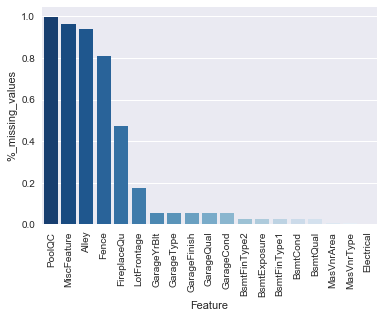

In [8]:
miss_vals = pd.DataFrame(miss_vals)
miss_vals.columns = ['%_missing_values']
miss_vals['Feature'] = miss_vals.index

sns.set(style='darkgrid')
sns.barplot(x='Feature', y='%_missing_values', data=miss_vals, palette=sns.color_palette("Blues_r", 19))
plt.xticks(rotation=90)
plt.show()

##### Distribution plot of target variable `SalePrice`

A distribution plot of the `SalePrice` target variable shows significant skew.  This is addressed through a log transformation of the target variable.

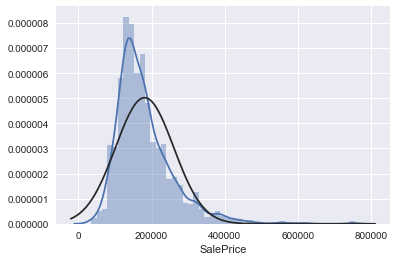

In [9]:
sns.distplot(train.SalePrice, fit=norm)
plt.show()

In [10]:
print('Skew of SalePrice: ', train.SalePrice.skew())

Skew of SalePrice:  1.8828757597682129


##### Transform the target variable `SalePrice`

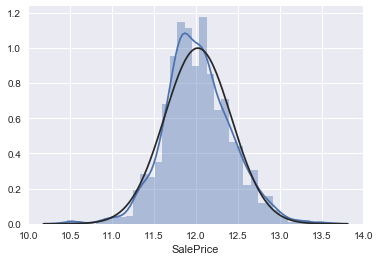

In [11]:
SalePriceLog = np.log1p(train.SalePrice)
sns.distplot(SalePriceLog, fit=norm)
plt.show()

In [12]:
print('Skew of log1p(SalePrice): ', SalePriceLog.skew())

Skew of log1p(SalePrice):  0.12134661989685333


A plot of the residuals shows that the variable's skewness has been appropriately dealt with.

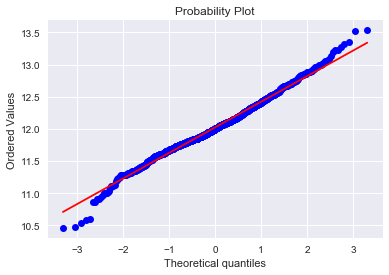

In [13]:
fig = plt.figure()
resid = stats.probplot(SalePriceLog, plot=plt)
plt.show()

##### Separate features into numeric and categorical data frames

Initial exploration of the feature data types indicate numeric and non-numeric (categorical) data.  Let's look take a closer look at the data for each type.

In [14]:
num_data = train.select_dtypes(include=[np.number])
cat_data = train.select_dtypes(exclude=[np.number])
print('Numeric columns: ', num_data.shape[1])
print('Categorical columns: ', cat_data.shape[1])

Numeric columns:  38
Categorical columns:  43


In [15]:
del num_data['Id']

#### Numerical Features EDA

##### Correlation of numeric features

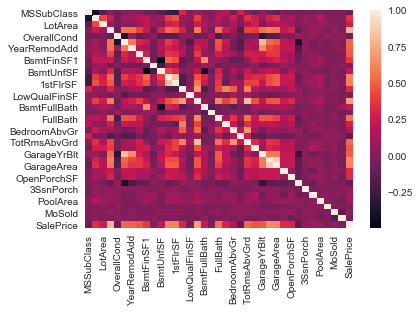

In [16]:
corr = num_data.corr()
sns.heatmap(corr)
plt.show()

##### Highest positively correlated features with target variable `SalePrice`

In [17]:
print(corr.SalePrice.sort_values(ascending=False)[1:10])

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


##### `SalePrice` correlation matrix

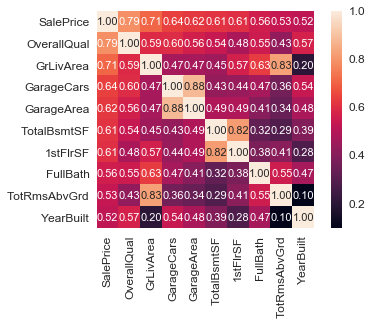

In [18]:
k = 10
cols = corr.nlargest(k, 'SalePrice').index
cm = np.corrcoef(num_data[cols].values.T)
sns.set(font_scale=1.2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The correlation matrices show a high correlation between the `SalePrice` target variable and `OverallQual` (overall quality score), `GrLivArea` (above grade/ground living area), `GarageCars/Area` (garage size), `TotalBsmtSF` (total basement square feet), and `1stFlrSF` (first floor square feet).

##### Median `SalePrice` by `OverallQual`

The median `SalePrice` by `OverallQual` score follows.

In [19]:
pivot = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
pivot.sort_values(by='SalePrice', ascending=False)

,SalePrice
OverallQual,
10,432390
9,345000
8,269750
7,200141
6,160000
5,133000
4,108000
3,86250
2,60000


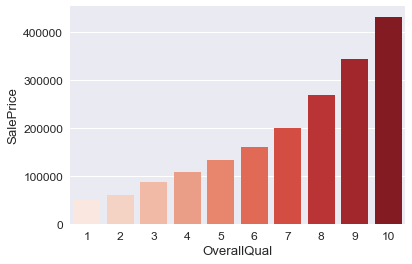

In [20]:
sns.barplot(x=pivot.index, y='SalePrice', data=pivot, palette=sns.color_palette("Reds", 10))
plt.show()

##### Joint plot of `GrLivArea` and `SalePrice`

A joint plot `GrLivArea` (above grade living area) and `SalePrice` reinforces the notion that these are two highly correlated features.

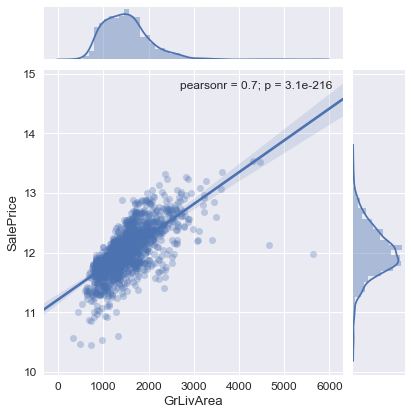

In [21]:
sns.jointplot(x=train.GrLivArea, y=np.log(train.SalePrice), kind='reg', scatter_kws={'alpha':0.3})
plt.show()

##### Distribution plots for numerical features

Distribution plots of the numerical features shows that some of these features are continous variables while others are discrete variables, and therefore likely categorical features.

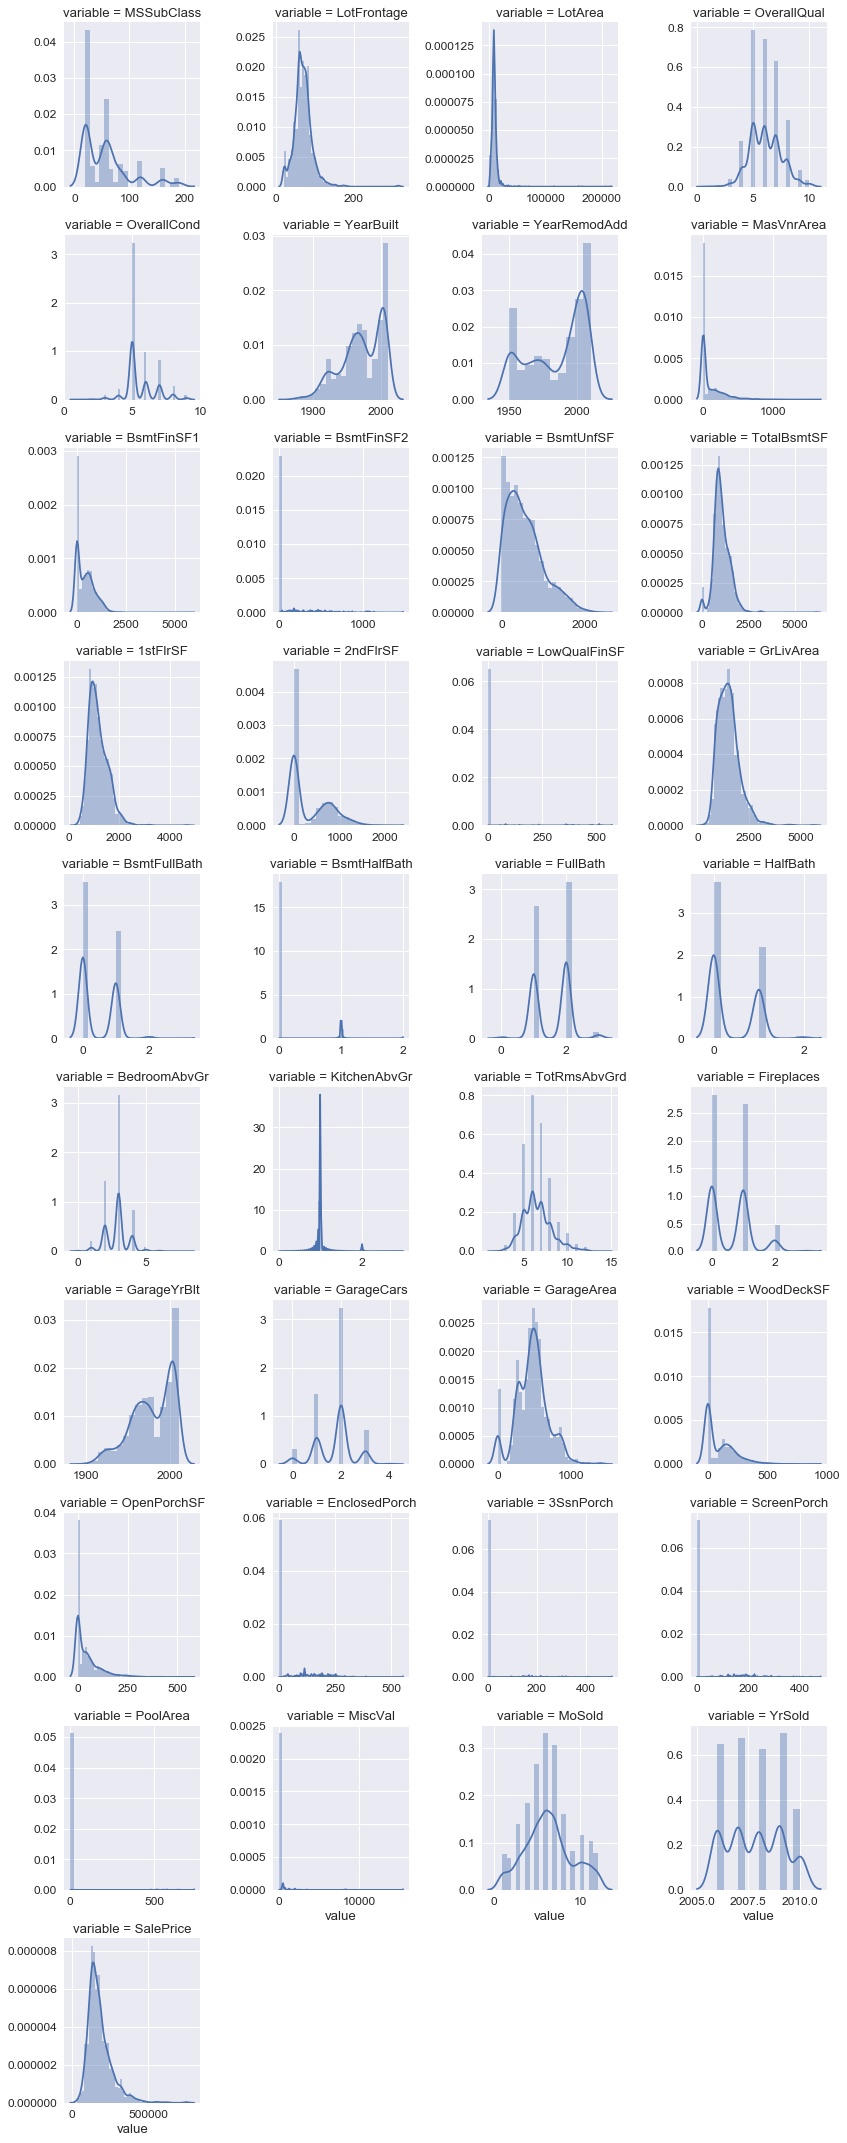

In [22]:
num = [f for f in train.columns if train.dtypes[f] != 'object']
num.remove('Id')
nd = pd.melt(frame=train, value_vars=num)
n1 = sns.FacetGrid(data=nd, col='variable', col_wrap=4, sharex=False, sharey=False)
n1 = n1.map(sns.distplot, 'value')
n1
plt.show()

##### Transform target variable `SalePrice` to log(1 + `SalePrice`): `SalePriceLog`

To adjust skewness of the target feature, the variable `SalePrice` is log-transformed and added to the training data as `SalePriceLog` as the revised target variable.

In [23]:
train['SalePriceLog'] = np.log1p(train.SalePrice)

#### Categorical Feature EDA

In [24]:
cat_data.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [25]:
cat_data.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

Median `SalePrice` by `KitchenQual` shows the following:

In [26]:
KQ_pivot = train.pivot_table(index='KitchenQual', values='SalePrice', aggfunc=np.median)
KQ_pivot.sort_values(by='SalePrice', ascending=False)

,SalePrice
KitchenQual,
Ex,316750
Gd,201400
TA,137000
Fa,115000


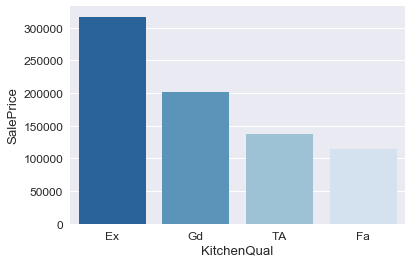

In [27]:
sns.barplot(x=KQ_pivot.index, y='SalePrice', data=KQ_pivot, order=['Ex', 'Gd', 'TA','Fa'], 
            palette=sns.color_palette("Blues_r", 4))
plt.show()

##### ANOVA for categorical features: p-values ranked score

Here I explore categorical features that exhibit low variance and thus are likely candidates for feature removal from the data set.  An ANOVA (Analysis of Variance) filter may be justified under the assumption that features with little to no variance will not contribute much to the explanatory power of any model.

In [28]:
cat = [f for f in train.columns if train.dtypes[f] == 'object']
def anova(df):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
        samples = []
        for cls in df[c].unique():
            s = df[df[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

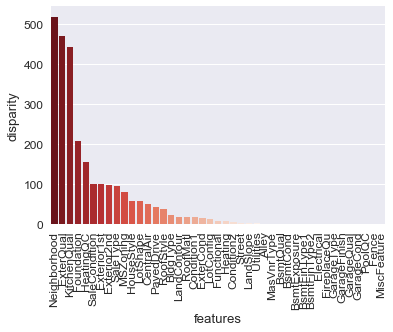

In [29]:
warnings.simplefilter('ignore')

cat_data['SalePrice'] = train.SalePrice.values
k = anova(cat_data)
k['disparity'] = np.log(1./k['pval'].values)
sns.barplot(x='features', y='disparity', data=k, palette=sns.color_palette('Reds_r', 27))
plt.xticks(rotation=90)
plt.show()

We can see from the above graph that there are several categorical features that are candidates for feature removal and dimension reduction.

Finally, I examine `SalePriceLog` by `Neighborhood` as well as box plots of the categorical features against `SalePriceLog` in order to visualize their variation with the target variable.

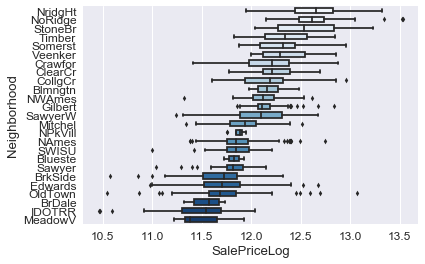

In [30]:
ranks = train.groupby('Neighborhood')['SalePriceLog'].median().fillna(0).sort_values(ascending=False).index

sns.boxplot(train.SalePriceLog, train.Neighborhood, order=ranks, palette=sns.color_palette('Blues', 25), 
            width=0.6, fliersize=4)
plt.show()

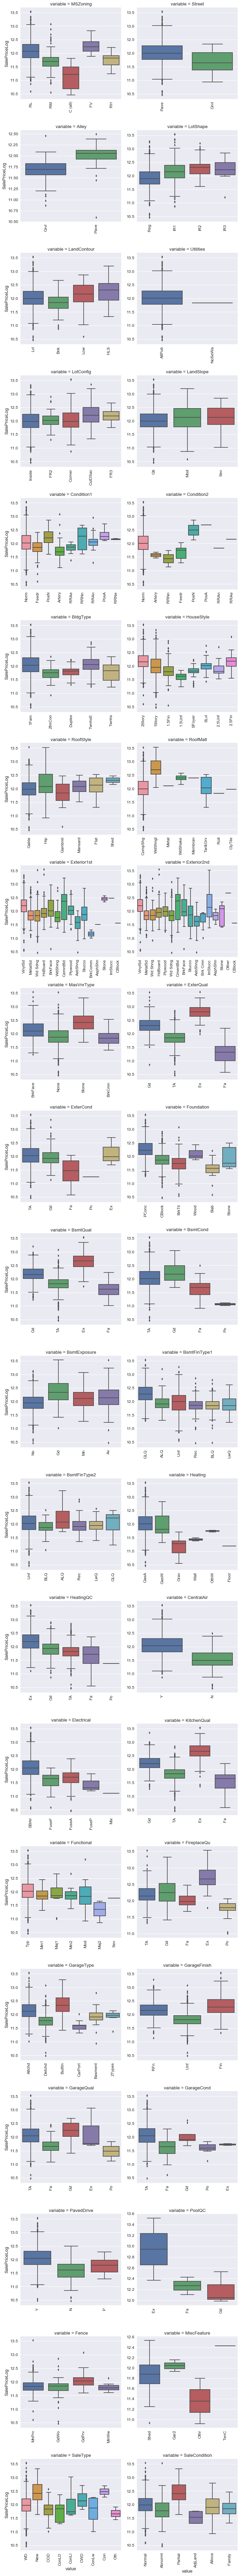

In [31]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    plt.xticks(rotation=90)
    
cat_plt = [f for f in train.columns if train.dtypes[f] == 'object']
cat_plt.remove('Neighborhood')

p = pd.melt(frame=train, id_vars='SalePriceLog', value_vars=cat_plt)
p1 = sns.FacetGrid(data=p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
p1 = p1.map(boxplot, 'value', 'SalePriceLog')
p1
plt.show()

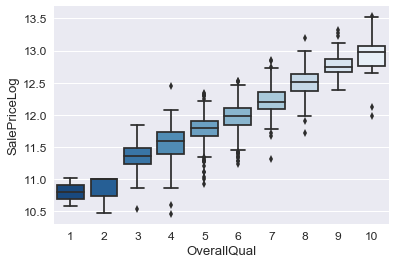

In [32]:
sns.boxplot(train.OverallQual, train.SalePriceLog, palette=sns.color_palette("Blues_r", 10))
plt.show()

#### Data Cleaning & Preprocessing

There are several data cleaning steps, which entail:
* Outlier removal in `GrLivArea`
* Log transformation of skewed features
* Missing data filling/imputation
* For Categorical features: conversion of categorical text values to ordinal values
* Conversion of categorical feature data types from ordinal to type:`category` for later dummy variable conversion

##### Remove outliers in `GrLivArea`

In [33]:
train.GrLivArea.sort_values(ascending=False)[:5]

1298    5642
523     4676
1182    4476
691     4316
1169    3627
Name: GrLivArea, dtype: int64

In [34]:
train = train.drop(train[train.GrLivArea >= 4676].index)

In [35]:
train.GrLivArea.sort_values(ascending=False)[:2]

1182    4476
691     4316
Name: GrLivArea, dtype: int64

##### Combine train and test sets for data preprocessing

In [36]:
alldata = pd.concat((train.loc[:, 'MSSubClass':], test.loc[:, 'MSSubClass':]))
alldata.shape

(2917, 81)

##### Transform skewed features

In [37]:
num_data.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [38]:
alldata[num_data.columns].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,61,0,0,0,0,0,2,2008,208500.0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,298,0,0,0,0,0,0,5,2007,181500.0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,42,0,0,0,0,0,9,2008,223500.0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,35,272,0,0,0,0,2,2006,140000.0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,192,84,0,0,0,0,0,12,2008,250000.0


In [39]:
skewed_feats = train[num_data.columns].apply(lambda x: stats.skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats = skewed_feats[:(len(skewed_feats)-1)]
skewed_feats

alldata[skewed_feats] = np.log1p(alldata[skewed_feats])

##### Missing data

In [40]:
total = alldata.isnull().sum().sort_values(ascending=False)
percent = (alldata.isnull().sum() / alldata.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(36)

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
SalePriceLog,1459,0.500171
SalePrice,1459,0.500171
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageQual,159,0.054508
GarageFinish,159,0.054508


##### Fill missing data

In [41]:
alldata.PoolQC = alldata.PoolQC.fillna('None')
alldata.MiscFeature = alldata.MiscFeature.fillna('None')
alldata.Alley = alldata.Alley.fillna('None')
alldata.Fence = alldata.Fence.fillna('None')
alldata.FireplaceQu = alldata.FireplaceQu.fillna('None')
alldata.PoolQC = alldata.PoolQC.fillna('None')

for col in ('GarageQual', 'GarageFinish', 'GarageCond', 'GarageType'):
    alldata[col] = alldata[col].fillna('None')
    
for col in ('BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1'):
    alldata[col] = alldata[col].fillna('None')

alldata.MasVnrType = alldata.MasVnrType.fillna('None')
alldata.MSZoning = alldata.MSZoning.fillna(alldata.MSZoning.mode()[0])
alldata.Functional = alldata.Functional.fillna('Typ')
alldata.Electrical = alldata.Electrical.fillna(alldata.Electrical.mode()[0])
alldata.KitchenQual = alldata.KitchenQual.fillna(alldata.KitchenQual.mode()[0])
alldata.Exterior1st = alldata.Exterior1st.fillna(alldata.Exterior1st.mode()[0])
alldata.Exterior2nd = alldata.Exterior2nd.fillna(alldata.Exterior2nd.mode()[0])
alldata.SaleType = alldata.SaleType.fillna(alldata.SaleType.mode()[0])
alldata.Utilities = alldata.Utilities.fillna(alldata.Utilities.mode()[0])

##### Impute `LotFrontage` missing values by median of `Neighborhood`

In [42]:
LF_by_NH = train.LotFrontage.groupby(train.Neighborhood)

for key, group in LF_by_NH:
    idx = (alldata.Neighborhood == key) & (alldata.LotFrontage.isnull())
    alldata.loc[idx, 'LotFrontage'] = group.median()

##### Fill missing values with 0 for numeric variables

In [43]:
alldata.MasVnrArea.fillna(0, inplace=True)
alldata.BsmtFinSF1.fillna(0, inplace=True)
alldata.BsmtFinSF2.fillna(0, inplace=True)
alldata.BsmtUnfSF.fillna(0, inplace=True)
alldata.TotalBsmtSF.fillna(0, inplace=True)
alldata.BsmtFullBath.fillna(0, inplace=True)
alldata.BsmtHalfBath.fillna(0, inplace=True)
alldata.GarageCars.fillna(0, inplace=True)
alldata.GarageArea.fillna(0, inplace=True)
alldata.GarageYrBlt.fillna(0.0, inplace=True)
alldata.PoolArea.fillna(0, inplace=True)

In [44]:
total = alldata.isnull().sum().sort_values(ascending=False)
percent = (alldata.isnull().sum() / alldata.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
SalePriceLog,1459,0.500171
SalePrice,1459,0.500171
ExterCond,0,0.000000
ExterQual,0,0.000000
Exterior1st,0,0.000000


##### Convert categorical values to ordinal values

Based on the data dictionary documentation, several categorical features have ordinal values applied by mapping a list of those features to a corresponding dictionary of key-value pairs.  This is executed in the following two code blocks.

In [45]:
dict1 = {np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
name1 = np.array(['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
                  'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'])

for i in name1:
    alldata[i] = alldata[i].map(dict1).astype(float)

In [46]:
alldata.BsmtExposure = alldata.BsmtExposure.map({np.nan: 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}).astype(float)

dict2 = {np.nan: 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
alldata.BsmtFinType1 = alldata.BsmtFinType1.map(dict2).astype(float)
alldata.BsmtFinType2 = alldata.BsmtFinType2.map(dict2).astype(float)

alldata.Functional = alldata.Functional.map({np.nan: 0, 'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 
                                             'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}).astype(float)
alldata.GarageFinish = alldata.GarageFinish.map({np.nan: 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}).astype(float)
alldata.Fence = alldata.Fence.map({np.nan: 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}).astype(float)
alldata.CentralAir = (alldata.CentralAir == 'Y') * 1.0

##### Low variance categorical features: Near Zero Variance function and feature removal

I remove categorical features with near zero variance in this section, accomplished by defining a function.

This function applies the near-zero variance rules in Kuhn, Johnson's Applied Predictive Modeling textbook to categorical variables in a pandas dataframe. It uses a 10% threshold for fraction of unique values to total number of records in the data, and a ratio of 20 for the proportion of the most frequently occuring category to the ratio of the second most frequently occuring category.

[Near-zero variance means that the] fraction of unique values over the sample size is low (say 10%) [...] [and the] ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large (say around 20). If both of these criteria are true and the model in question is susceptible to this type of predictor, it may be advantageous to remove the variable from the model.

-- Kuhn, M., & Johnson, K. (2013). Applied predictive modeling, New York, NY: Springer.

See also: https://stats.stackexchange.com/questions/145602/justification-for-feature-selection-by-removing-predictors-with-near-zero-variance

In [47]:
def nearZeroVarPreds(df):
    nearZeroVarPreds = []
    for column in df:
        if df[column].dtype.name == 'category':
            
            # fraction of unique categories to total no. of records
            fractionOfUniqValues = df[column].cat.codes.value_counts().tolist()[0] / len(df[column])
            
            # returns values counts, sorted, as a list
            colValCounts = df[column].cat.codes.value_counts().tolist() 
            
            if len(colValCounts) > 1:
                ratioOfCatFreqs = colValCounts[1] / colValCounts[0] # ratio of 2nd to 1st most frequently occuring category
            else:
                ratioOfCatFreqs = 1
            if fractionOfUniqValues > 0.90 and ratioOfCatFreqs <= 0.05:
                nearZeroVarPreds.append(column)
    return(nearZeroVarPreds)

In [48]:
cat_columns = alldata.select_dtypes(['object']).columns
cat_columns

Index(['Alley', 'BldgType', 'Condition1', 'Condition2', 'Electrical',
       'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating',
       'HouseStyle', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape',
       'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive',
       'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street',
       'Utilities'],
      dtype='object')

In [49]:
alldata[cat_columns] = alldata[cat_columns].apply(lambda x: x.astype('category'))

In [50]:
variable_list = nearZeroVarPreds(alldata)
variable_list

['Alley',
 'Condition2',
 'Heating',
 'LandSlope',
 'MiscFeature',
 'RoofMatl',
 'Street',
 'Utilities']

In [51]:
for var in variable_list:
    alldata = alldata.drop(var, axis=1)
print(alldata.shape)

(2917, 73)


##### Low variance numeric features: sklearn `VarianceThreshold`

For the numeric features, I'll import and execute a variance check using scikit learn's `VarianceThreshold` feature selector, which removes all low-variance features.

In [52]:
from sklearn.feature_selection import VarianceThreshold

In [53]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

data2 = alldata.select_dtypes(include=numerics)
data2 = data2.fillna(0)
data2.shape

(2917, 55)

In [54]:
selector = VarianceThreshold()
data3 = selector.fit_transform(data2)
data3.shape

(2917, 55)

##### Function to convert categorical feature data types from ordinal to type:`category`

Here I convert the categorical feature data types from ordinal/numeric data types to `category`.  This facilitates the next (and final) data preprocessing step.

In [55]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def make_factor(data, var, fill_na=None):
    if fill_na is not None:
        data[var].fillna(fill_na, inplace=True)
    le.fit(data[var])
    data[var] = le.transform(data[var])
    return data

In [56]:
name3 = np.array(['MSSubClass', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 
                  'BldgType', 'HouseStyle', 'RoofStyle', 'Foundation', 'PavedDrive', 'SaleCondition', 
                  'MSZoning', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'GarageType', 
                  'SaleType'])

for i in name3:
    make_factor(data=alldata, var=i)

In [57]:
cat_columns = cat_data.columns

In [58]:
cat_columns = cat_columns.tolist()

In [59]:
cat_columns.extend(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
                    'GarageYrBlt', 'MoSold', 'YrSold'])
for x in variable_list:
    cat_columns.remove(x)

cat_columns.remove('SalePrice')

In [60]:
alldata[cat_columns] = alldata[cat_columns].apply(lambda x: x.astype('category'))

In [61]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Data columns (total 73 columns):
1stFlrSF         2917 non-null float64
2ndFlrSF         2917 non-null float64
3SsnPorch        2917 non-null float64
BedroomAbvGr     2917 non-null int64
BldgType         2917 non-null category
BsmtCond         2835 non-null category
BsmtExposure     2835 non-null category
BsmtFinSF1       2917 non-null float64
BsmtFinSF2       2917 non-null float64
BsmtFinType1     2838 non-null category
BsmtFinType2     2837 non-null category
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2836 non-null category
BsmtUnfSF        2917 non-null float64
CentralAir       2917 non-null category
Condition1       2917 non-null category
Electrical       2917 non-null category
EnclosedPorch    2917 non-null float64
ExterCond        2917 non-null category
ExterQual        2917 non-null category
Exterior1st      2917 non-null category
Exterior2nd      2917 non

##### Create dummy variables from categorical features

Finally, I create dummy variables from the categorical features using pandas' `get_dummies` function.

This greatly expands the data set's number of features and its dimensionality, as multi-category features are have a specific `dummy` feature created for each possible category of that feature.

In [62]:
alldata = pd.get_dummies(alldata)

In [63]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Columns: 583 entries, 1stFlrSF to YrSold_2010
dtypes: float64(25), int64(5), uint8(553)
memory usage: 2.2 MB


In [64]:
alldata.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,YearRemodAdd_2006,YearRemodAdd_2007,YearRemodAdd_2008,YearRemodAdd_2009,YearRemodAdd_2010,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,6.753438,6.751101,0.0,3,6.561031,0.0,1.0,0.000000,5.017280,0.000000,...,0,0,0,0,0,0,0,1,0,0
1,7.141245,0.000000,0.0,3,6.886532,0.0,0.0,0.693147,5.652489,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,6.825460,6.765039,0.0,3,6.188264,0.0,1.0,0.000000,6.075346,0.000000,...,0,0,0,0,0,0,0,1,0,0
3,6.869014,6.629363,0.0,3,5.379897,0.0,1.0,0.000000,6.293419,5.609472,...,0,0,0,0,0,1,0,0,0,0
4,7.044033,6.960348,0.0,4,6.486161,0.0,1.0,0.000000,6.196444,0.000000,...,0,0,0,0,0,0,0,1,0,0


##### Split data into training set, test set

In [65]:
train_rev = alldata[alldata.SalePrice.notnull()]

In [66]:
test_rev = alldata[alldata.SalePrice.isnull()]

In [67]:
test_rev = test_rev.drop(['SalePrice', 'SalePriceLog'], axis=1)

In [68]:
X = train_rev.drop(['SalePrice', 'SalePriceLog'], axis=1)

In [69]:
X.shape

(1458, 581)

In [70]:
y = train_rev['SalePriceLog']

In [71]:
y.shape

(1458,)

#### Linear Regression

In [72]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [73]:
X_lm = X[['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']]
X_lm.head()

,GrLivArea,GarageArea,TotalBsmtSF,1stFlrSF
0,7.444833,548.0,856.0,6.753438
1,7.141245,460.0,1262.0,7.141245
2,7.488294,608.0,920.0,6.825460
3,7.448916,642.0,756.0,6.869014
4,7.695758,836.0,1145.0,7.044033


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_lm, y, test_size=0.2, random_state=48)

In [75]:
print(X_train.shape)
print(X_test.shape)

(1166, 4)
(292, 4)


##### Single Linear Regression

Initially I apply an ordinary least squares Linear Regression to `GrLivArea` (above-ground livable area), which is the highest correlated single variable in the data set.

The purpose is to establish a simple baseline model result and to create a 2D visualization of the single feature against `SalePriceLog`. 

In [76]:
X_train_slr = X_train.GrLivArea.reshape((1166, 1))
X_test_slr = X_test.GrLivArea.reshape((292, 1))

In [77]:
# Create linear regression object
lm_slr = linear_model.LinearRegression()

# Train the model using the training sets
lm_slr.fit(X_train_slr, y_train)

# Make predictions using the testing set
predictions_slr = lm_slr.predict(X_test_slr)

# The coefficients
print('Coefficients: \n', lm_slr.coef_)
# The mean squared error
print("Mean Squared Error: %.2f"
      % mean_squared_error(y_test, predictions_slr))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, predictions_slr))

Coefficients: 
 [0.90282583]
Mean Squared Error: 0.05
R-squared: 0.57


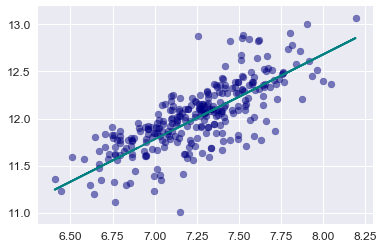

In [78]:
plt.scatter(X_test_slr, y_test,  color='navy', alpha=0.5)
plt.plot(X_test_slr, predictions_slr, color='teal', linewidth=2)
plt.show()

The result gives a fairly low $R^{2}$ of 57%.

I'll attempt to improve on this by adding features to the variable set and executing a mutiple regression model.

##### Multiple Regression

This regression model includes four features in the independent variable set: `GrLivArea`, `GarageArea`, `TotalBsmtSF`, `1stFlrSF`

These were four of the highest correlated variable with the target variable `SalePriceLog`.

In [79]:
# Create linear regression object
lm = linear_model.LinearRegression()

# Train the model using the training sets
lm.fit(X_train, y_train)

# Make predictions using the testing set
predictions = lm.predict(X_test)

# The coefficients
print('Coefficients: \n', lm.coef_)
# The mean squared error
print("Mean Squared Error: %.2f"
      % mean_squared_error(y_test, predictions))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, predictions))

Coefficients: 
 [ 5.86892727e-01  5.51731591e-04  3.41348965e-04 -6.78345334e-02]
Mean Squared Error: 0.03
R-squared: 0.75


$R^{2}$ improved to 75%, and MSE declined as well.

However, while this is an improvement over the simple model, it's not a very robust result.  I'll execute a variant regression model, a Decsion Treee Regression, to see if model results and explanatory power can be improved further.

#### Decision Tree Regression

A decision tree where the target variable can take on continuous values is a regression tree.  The observed features (the branches) are used in a predictive model concerning the target variable values (the leaves).

Similar to the linear model approach, results from a single feature and multi-feature decision tree regression are presented.

In [80]:
X_dt = X[['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_dt, y, test_size=0.2, random_state=48)

##### Siingle Feature Decision Tree

Decision Tree model performance is initially assessed via a single feature model with the highest correlated feature `GrLivArea`.  This establishes a simple baseline model result and allows a 2D visualization of the regression of the branch against `SalePriceLog`.

In [82]:
X_train_sdt = X_train.GrLivArea.reshape((1166, 1))
X_test_sdt = X_test.GrLivArea.reshape((292, 1))

In [83]:
# Import the necessary modules and libraries
from sklearn.tree import DecisionTreeRegressor

# Fit regression model
regr_1_sdt = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
regr_2_sdt = DecisionTreeRegressor(criterion='friedman_mse', max_depth=4)
regr_1_sdt.fit(X_train_sdt, y_train)
regr_2_sdt.fit(X_train_sdt, y_train)

# Predict
pred_1_sdt = regr_1_sdt.predict(X_test_sdt)
pred_2_sdt = regr_2_sdt.predict(X_test_sdt)

In [84]:
print(regr_1_sdt.score(X_test_sdt, y_test))
print(regr_1_sdt.feature_importances_)

0.508483557484072
[1.]


In [85]:
print(regr_2_sdt.score(X_test_sdt, y_test))
print(regr_2_sdt.feature_importances_)

0.5322109535681104
[1.]


Results show a fairly low $R^{2}$ score for either a maximum depth of 2 ($R^{2}$ of 50.8%) or a maximum depth of 4 ($R^{2}$ of 53.2%).

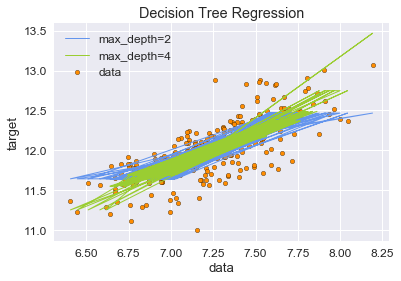

In [86]:
# Plot the results
plt.figure()
plt.scatter(X_test_sdt, y_test, s=20, edgecolor='black', c='darkorange', label='data')
plt.plot(X_test_sdt, pred_1_sdt, color='cornflowerblue', label='max_depth=2', linewidth=1)
plt.plot(X_test_sdt, pred_2_sdt, color='yellowgreen', label='max_depth=4', linewidth=1)
plt.xlabel('data')
plt.ylabel('target')
plt.title('Decision Tree Regression')
plt.legend()
plt.show()

A plot of model results shows a general linear pattern with high variability, in line with the low $R^{2}$ scores.

Expanding the feature set to four branches may improve results, and this is examined in the following section.

##### Multiple Feature Decision Tree

The same feature set used in the linear regression model is used in this multi-feature decision tree model: `GrLivArea`, `GarageArea`, `TotalBsmtSF`, `1stFlrSF`

In [87]:
# Import the necessary modules and libraries
from sklearn.tree import DecisionTreeRegressor

# Fit regression model
regr_1 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
regr_2 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
pred_1 = regr_1.predict(X_test)
pred_2 = regr_2.predict(X_test)

In [88]:
print(regr_1.score(X_test, y_test))
print(regr_1.feature_importances_)

0.5545303617568046
[0.67166283 0.20337295 0.12496423 0.        ]


In [89]:
print(regr_2.score(X_test, y_test))
print(regr_2.feature_importances_)

0.6966108194741298
[0.54032682 0.23899804 0.2157727  0.00490245]


Significant improvements in model results are obtained in multi-feature decision tree regression relative to single feature, particularly with a maximum depth of 5: the $R^{2}$ improves to 69.7%

In the final section, a boosting approach will be examined with the goal of improving $R^{2}$ scoring and producing reasonably precise predictions.

#### Elastic Net Regression

Linear regression with combined L1 and L2 priors as regularizer.  In the fitting of linear or logistic regression models, the elastic net is a regularized regression method that linearly combines the L1 and L2 penalties of the LASSO and Ridge methods.

The model makes use of the entire feature set of variables.  Due to the large number of categorical variables that are converted to dummy variables, this data set is a large sparse matrix of 583 features.

Elastic net regression is a regularized linear regression technique that handles sparse matrices well, and is a boosting algorithm that penalizes regression coefficents with the L1 (LASSO) and L2 (Ridge) penalties.

I employ a grid search of the L1 ratio to optimize the model parameters, which is a combination of the L1 and L2 penalties.

In [90]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

In [91]:
steps = [('scaler', StandardScaler()), ('elasticnet', ElasticNet())]

In [92]:
pipeline = Pipeline(steps)

In [93]:
parameters = {'elasticnet__l1_ratio':np.linspace(0, 1, 30)}

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
model = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=5)

In [96]:
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'elasticnet__l1_ratio': array([0.     , 0.03448, 0.06897, 0.10345, 0.13793, 0.17241, 0.2069 ,
       0.24138, 0.27586, 0.31034, 0.34483, 0.37931, 0.41379, 0.44828,
       0.48276, 0.51724, 0.55172, 0.58621, 0.62069, 0.65517, 0.68966,
       0.72414, 0.75862, 0.7931 , 0.82759, 0.86207, 0.89655, 0.93103,
       0.96552, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [97]:
y_pred = model.predict(X_test)
r2 = model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print('Tuned ElasticNet Alpha: {}'.format(model.best_params_))
print('Tuned ElasticNet R-squared: {}'.format(r2))
print('Tuned ElasticNet MSE: {}'.format(mse))

Tuned ElasticNet Alpha: {'elasticnet__l1_ratio': 0.0}
Tuned ElasticNet R-squared: 0.8897648075540748
Tuned ElasticNet MSE: 0.018583036892302306


The elastic net model's $R^{2}$ of 89% is a substantial improvement over the other approaches' scoring and has the lowest MSE of the alternatives.

#### Conclusion

Elastic net clearly provides superior results relative to the alternative models.  By applying coefficient penalties, the model avoids overfitting and can efficiently process a large, sparse feature set of categorical dummy variables through Ridge/LASSO regularization.  The model provides good predictive results on the test data and can likely be improved with additional parameter tuning.  It's a fantastic and versatile regression model.